<a href="https://colab.research.google.com/github/piambak/Tax-Court-Verdict/blob/main/KTTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This source code was used at the Faras Akbar's KTTA

# Importing libraries that are planned to be used in the process

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb


from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_regression

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import re
import nltk

import os

# Reading the dataset, dropping null values and creating a copy of the dataframe for the modelling process

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/KTTA/Data/putusan_data2.csv', delimiter='|', encoding = "utf8")
df.dropna(inplace=True)
df.head()

,putusan,jenis_sengketa,jenis_pajak,tahun_pajak,hasil_putusan,tahun_putusan,teks_raw,teks_html,ketua
0,321/B/PK/PJK/2023,Peninjauan Kembali,PPN & PPnBM,2016,Menolak permintaan peninjauan kembali,2023,PUTUSAN MAHKAMAH AGUNG 321/B/PK/PJK/2023 DEMI ...,"<h1 style=""text-align:center""><strong>PUTUSAN ...","Dr. H. Yulius, S.H., M.H."
1,512/B/PK/PJK/2023,Peninjauan Kembali,PPh Pasal 22,2016,Menolak permintaan peninjauan kembali,2023,PUTUSAN MAHKAMAH AGUNG 512/B/PK/PJK/2023 DEMI ...,"<h1 style=""text-align:center""><strong>PUTUSAN ...","Dr. H. Yulius, S.H., M.H."
2,253/B/PK/PJK/2023,Peninjauan Kembali,PPh Badan,2017,Menolak permintaan peninjauan kembali,2023,PUTUSAN MAHKAMAH AGUNG 253/B/PK/PJK/2023 DEMI ...,"<h1 style=""text-align:center""><strong>PUTUSAN ...","Dr. H. Yulius, S.H., M.H."
3,304/B/PK/PJK/2023,Peninjauan Kembali,PPN & PPnBM,2016,Menolak permintaan peninjauan kembali,2023,PUTUSAN MAHKAMAH AGUNG 304/B/PK/PJK/2023 DEMI ...,"<h1 style=""text-align:center""><strong>PUTUSAN ...","Dr. H. Yulius, S.H., M.H."
4,322/B/PK/PJK/2023,Peninjauan Kembali,PPN & PPnBM,2017,Menolak permintaan peninjauan kembali,2023,PUTUSAN MAHKAMAH AGUNG 322/B/PK/PJK/2023 DEMI ...,"<h1 style=""text-align:center""><strong>PUTUSAN ...","Dr. H. Yulius, S.H., M.H."


In [48]:
def class_distribution_table(df, column_name):
    class_counts = df[column_name].value_counts().reset_index()
    class_counts.columns = [column_name, 'count']
    return class_counts

hasil_putusan_table = class_distribution_table(df, 'hasil_putusan')
print(hasil_putusan_table)

jenis_pajak_table = class_distribution_table(df, 'jenis_pajak')
print(jenis_pajak_table)

jenis_pajak_table = class_distribution_table(df, 'jenis_sengketa')
print(jenis_pajak_table)

jenis_pajak_table = class_distribution_table(df, 'tahun_pajak')
print(jenis_pajak_table)

jenis_pajak_table = class_distribution_table(df, 'tahun_putusan')
print(jenis_pajak_table)

                                        hasil_putusan  count
0               Menolak permintaan peninjauan kembali   1383
1                              Mengabulkan Seluruhnya   1269
2                                             Menolak   1236
3                                Mengabulkan Sebagian    340
4                                Tidak Dapat Diterima    165
5           Mengabulkan permohonan peninjauan kembali    159
6          Permintaan dinyatakan tidak dapat diterima     92
7                                          Pencabutan     52
8                                         Membatalkan     39
9                                         Membetulkan      8
10  Mengabulkan permohonan keberatan hak uji materiil      1
             jenis_pajak  count
0            PPN & PPnBM   2354
1            Bea & Cukai    912
2              PPh Badan    421
3           Pajak Daerah    303
4           PPh Pasal 26    268
5           PPh Pasal 23    187
6   PPh Pasal 4 Ayat (2)     88
7           

In [ ]:
row = df.index[df['hasil_putusan'] == 'Mengabulkan permohonan keberatan hak uji materiil'].tolist()
print(row)

[1644]


In [ ]:
df1 = df.copy()
df1.drop(labels=[1644], axis=0)
indexDrop = df1[ (df1['hasil_putusan'] == "Mengabulkan permohonan keberatan hak uji materiil")].index
df1.drop(indexDrop , inplace=True)
df1.drop(columns=['putusan', 'teks_html', 'teks_raw'], inplace=True)

In [ ]:
df.info()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4744 entries, 0 to 6164
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   putusan         4744 non-null   object
 1   jenis_sengketa  4744 non-null   object
 2   jenis_pajak     4744 non-null   object
 3   tahun_pajak     4744 non-null   int64 
 4   hasil_putusan   4744 non-null   object
 5   tahun_putusan   4744 non-null   int64 
 6   teks_raw        4744 non-null   object
 7   teks_html       4744 non-null   object
 8   ketua           4744 non-null   object
dtypes: int64(2), object(7)
memory usage: 499.7+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 4743 entries, 0 to 6164
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   jenis_sengketa  4743 non-null   object
 1   jenis_pajak     4743 non-null   object
 2   tahun_pajak     4743 non-null   int64 
 3   hasil_putusan   4743 non-null   objec

# Seperating the dataset into target variables and independent variables

In [ ]:
df_cat = df1[['jenis_pajak', 'jenis_sengketa', 'ketua', 'tahun_pajak', 'tahun_putusan']]
df_target = df1['hasil_putusan']

# Creating Data Visualization

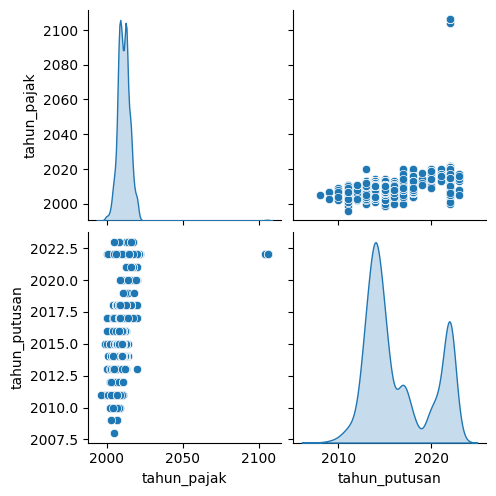

In [ ]:
# Create data visualization
sns.pairplot(df_cat, diag_kind='kde')
plt.show()

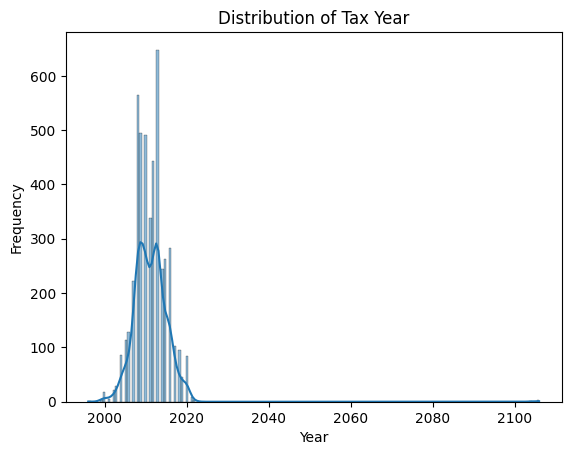

In [ ]:
sns.histplot(df['tahun_pajak'], kde=True)
plt.title('Distribution of Tax Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

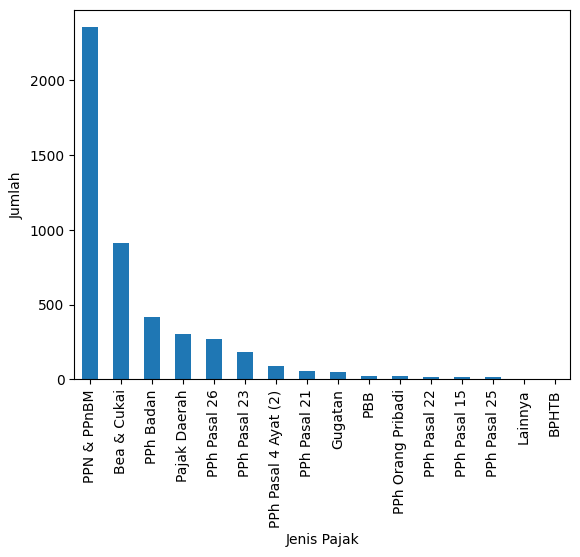

In [ ]:
df['jenis_pajak'].value_counts().plot(kind='bar')
plt.title('')
plt.xlabel('Jenis Pajak')
plt.ylabel('Jumlah')
plt.show()

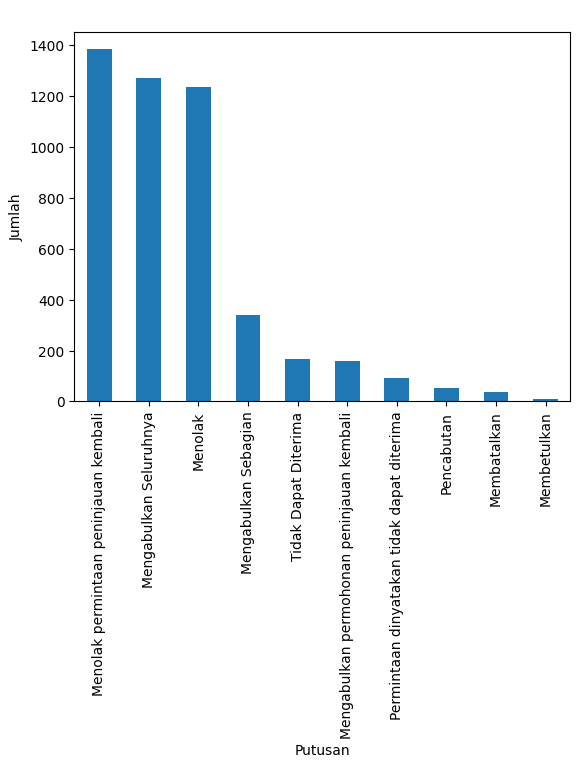

In [ ]:
df1['hasil_putusan'].value_counts().plot(kind='bar')
plt.title(' ')
plt.xlabel('Putusan')
plt.ylabel('Jumlah')
plt.show()

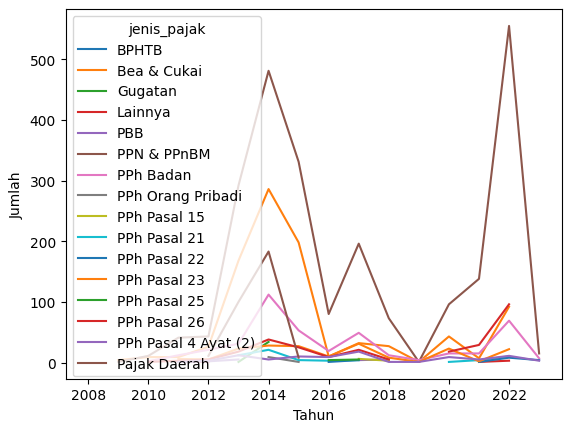

In [ ]:
counts = df.groupby(['tahun_putusan', 'jenis_pajak']).size().reset_index(name='count')

counts.pivot(index='tahun_putusan', columns='jenis_pajak', values='count').plot()
plt.title('')
plt.xlabel('Tahun')
plt.ylabel('Jumlah')
plt.show()

In [ ]:
# Check the distribution of the target variable
#sns.histplot(df['hasil_putusan'], kde=True)
#plt.show()

# Resetting indices to avoid NaNs during concatenation and performing one-hot encoding

In [ ]:
df_cat.reset_index(drop=True, inplace=True)
df_target.reset_index(drop=True, inplace=True)

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df_target= label_encoder.fit_transform(df_target)

df_target1 = pd.DataFrame(df_target, columns=['hasil_putusan'])
df_target1

,hasil_putusan
0,6
1,6
2,6
3,6
4,6
...,...
4738,6
4739,6
4740,8
4741,6


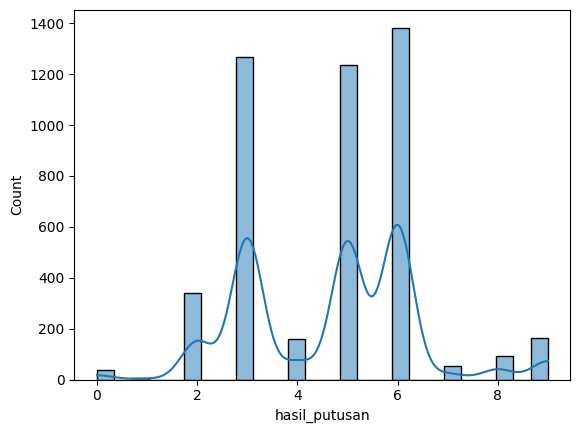

In [ ]:
# @title hasil_putusan

# Check the distribution of the target variable
sns.histplot(df_target1['hasil_putusan'], kde=True)
plt.show()

In [ ]:
frames = [df_cat, df_target1]
df_gabung = pd.concat(frames, axis=1, join='inner')

# Convert hasil_putusan to a categorical variable
df_gabung['hasil_putusan'] = df_gabung['hasil_putusan'].astype('category')

df_gabung

,jenis_pajak,jenis_sengketa,ketua,tahun_pajak,tahun_putusan,hasil_putusan
0,PPN & PPnBM,Peninjauan Kembali,"Dr. H. Yulius, S.H., M.H.",2016,2023,6
1,PPh Pasal 22,Peninjauan Kembali,"Dr. H. Yulius, S.H., M.H.",2016,2023,6
2,PPh Badan,Peninjauan Kembali,"Dr. H. Yulius, S.H., M.H.",2017,2023,6
3,PPN & PPnBM,Peninjauan Kembali,"Dr. H. Yulius, S.H., M.H.",2016,2023,6
4,PPN & PPnBM,Peninjauan Kembali,"Dr. H. Yulius, S.H., M.H.",2017,2023,6
...,...,...,...,...,...,...
4738,PBB,Peninjauan Kembali,"Widayatno Sastrohardjono, S.H., M.Sc.",2007,2009,6
4739,PPN & PPnBM,Peninjauan Kembali,"Widayatno Sastrohardjono, S.H., M.Sc.",2007,2009,6
4740,Bea & Cukai,Peninjauan Kembali,"Widayatno Sastrohardjono, S.H., M.Sc",2007,2009,8
4741,PPh Pasal 23,Peninjauan Kembali,"Widayatno Sastrohardjono, S.H., M.Sc.",2003,2009,6


Heatmap

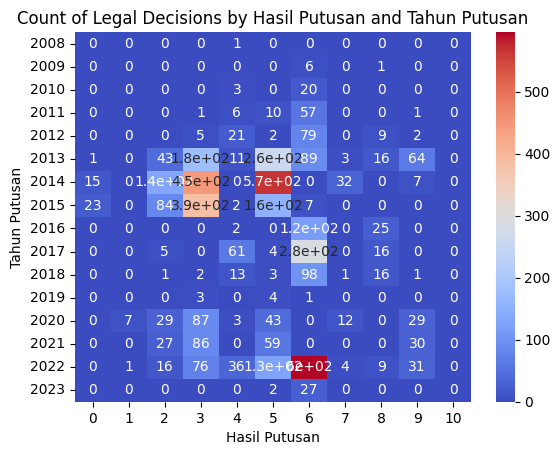

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert hasil_putusan to categorical column with explicit categories
df_gabung['hasil_putusan'] = pd.Categorical(df_gabung['hasil_putusan'], categories=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Group data by tahun_putusan and hasil_putusan, and count the number of occurrences
grouped = df_gabung.groupby(['tahun_putusan', 'hasil_putusan']).size().reset_index(name='count')

# Pivot the data to create a matrix of counts
pivot = grouped.pivot(index='tahun_putusan', columns='hasil_putusan', values='count')

# Create heatmap
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title('Count of Legal Decisions by Hasil Putusan and Tahun Putusan')
plt.xlabel('Hasil Putusan')
plt.ylabel('Tahun Putusan')
plt.show()

#  Exploratory Data Analysis

In [ ]:
def class_distribution_table(df, column_name):
    class_counts = df[column_name].value_counts().reset_index()
    class_counts.columns = [column_name, 'count']
    return class_counts

In [47]:
hasil_putusan_table = class_distribution_table(df_gabung, 'hasil_putusan')
print(hasil_putusan_table)

jenis_pajak_table = class_distribution_table(df_gabung, 'jenis_pajak')
print(jenis_pajak_table)

jenis_pajak_table = class_distribution_table(df_gabung, 'jenis_sengketa')
print(jenis_pajak_table)

   hasil_putusan  count
0              6   1383
1              3   1269
2              5   1236
3              2    340
4              9    165
5              4    159
6              8     92
7              7     52
8              0     39
9              1      8
10            10      0
    jenis_pajak  count
0             5   2353
1             1    912
2             6    421
3            15    303
4            13    268
5            11    187
6            14     88
7             9     60
8             2     47
9             4     23
10            7     20
11           10     19
12            8     18
13           12     17
14            3      6
15            0      1
   jenis_sengketa  count
0               0   2684
1               2   1646
2               1    413


Object Type Value

In [ ]:
print("Object type values:",np.count_nonzero(df_gabung.select_dtypes('object').columns))
print("___________________________________________________________________________________________")
print(df_gabung.select_dtypes('object').columns)
print("___________________________________________________________________________________________")

Object type values: 3
___________________________________________________________________________________________
Index(['jenis_pajak', 'jenis_sengketa', 'ketua'], dtype='object')
___________________________________________________________________________________________


In [ ]:
le = LabelEncoder()
df_gabung['jenis_pajak'] = le.fit_transform(df_gabung['jenis_pajak'])
df_gabung['jenis_sengketa'] = le.fit_transform(df_gabung['jenis_sengketa'])
df_gabung['ketua'] = le.fit_transform(df_gabung['ketua'])

Descriptive Statistic

In [ ]:
df_gabung.describe()

,jenis_pajak,jenis_sengketa,ketua,tahun_pajak,tahun_putusan
count,4743.000000,4743.000000,4743.000000,4743.000000,4743.000000
mean,5.891419,0.781151,203.865697,2011.257854,2016.419777
std,3.991796,0.930168,131.092655,4.809567,3.516582
min,0.000000,0.000000,0.000000,1996.000000,2008.000000
25%,5.000000,0.000000,90.000000,2008.000000,2014.000000
50%,5.000000,0.000000,177.000000,2011.000000,2015.000000
75%,6.000000,2.000000,309.000000,2013.000000,2020.000000
max,15.000000,2.000000,528.000000,2106.000000,2023.000000


Integer Type Value

In [ ]:
print("___________________________________________________________________________________________")
print("Int type values:",np.count_nonzero(df_gabung.select_dtypes('int').columns))
print(df_gabung.select_dtypes('int').columns)
print("___________________________________________________________________________________________")

___________________________________________________________________________________________
Int type values: 5
Index(['jenis_pajak', 'jenis_sengketa', 'ketua', 'tahun_pajak',
       'tahun_putusan'],
      dtype='object')
___________________________________________________________________________________________


Descriptive Statistic

In [ ]:
df_gabung.select_dtypes('int').agg(['count','min', 'max','mean','median','quantile','kurt','skew','var','std'])

,jenis_pajak,jenis_sengketa,ketua,tahun_pajak,tahun_putusan
count,4743.000000,4743.000000,4743.000000,4743.000000,4743.000000
min,0.000000,0.000000,0.000000,1996.000000,2008.000000
max,15.000000,2.000000,528.000000,2106.000000,2023.000000
mean,5.891419,0.781151,203.865697,2011.257854,2016.419777
median,5.000000,0.000000,177.000000,2011.000000,2015.000000
quantile,5.000000,0.000000,177.000000,2011.000000,2015.000000
kurt,0.199027,-1.695109,-0.860554,151.849472,-1.128798
skew,0.970525,0.447063,0.485906,7.849847,0.564730
var,15.934433,0.865212,17185.284152,23.131937,12.366349
std,3.991796,0.930168,131.092655,4.809567,3.516582


Outlier Detector

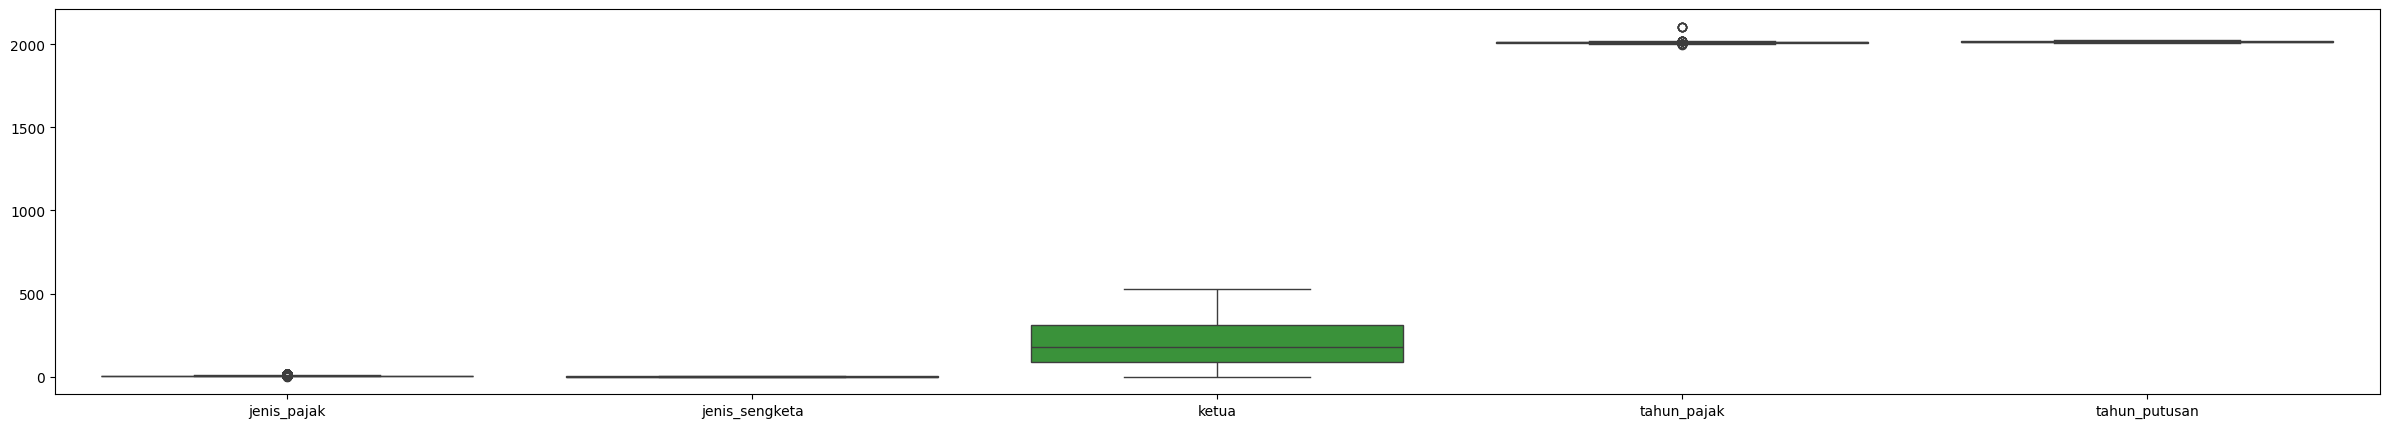

In [ ]:
plt.figure(figsize=(30,5))
sns.boxplot(data=df_gabung.select_dtypes('int'))
plt.show()

Distribution Variable

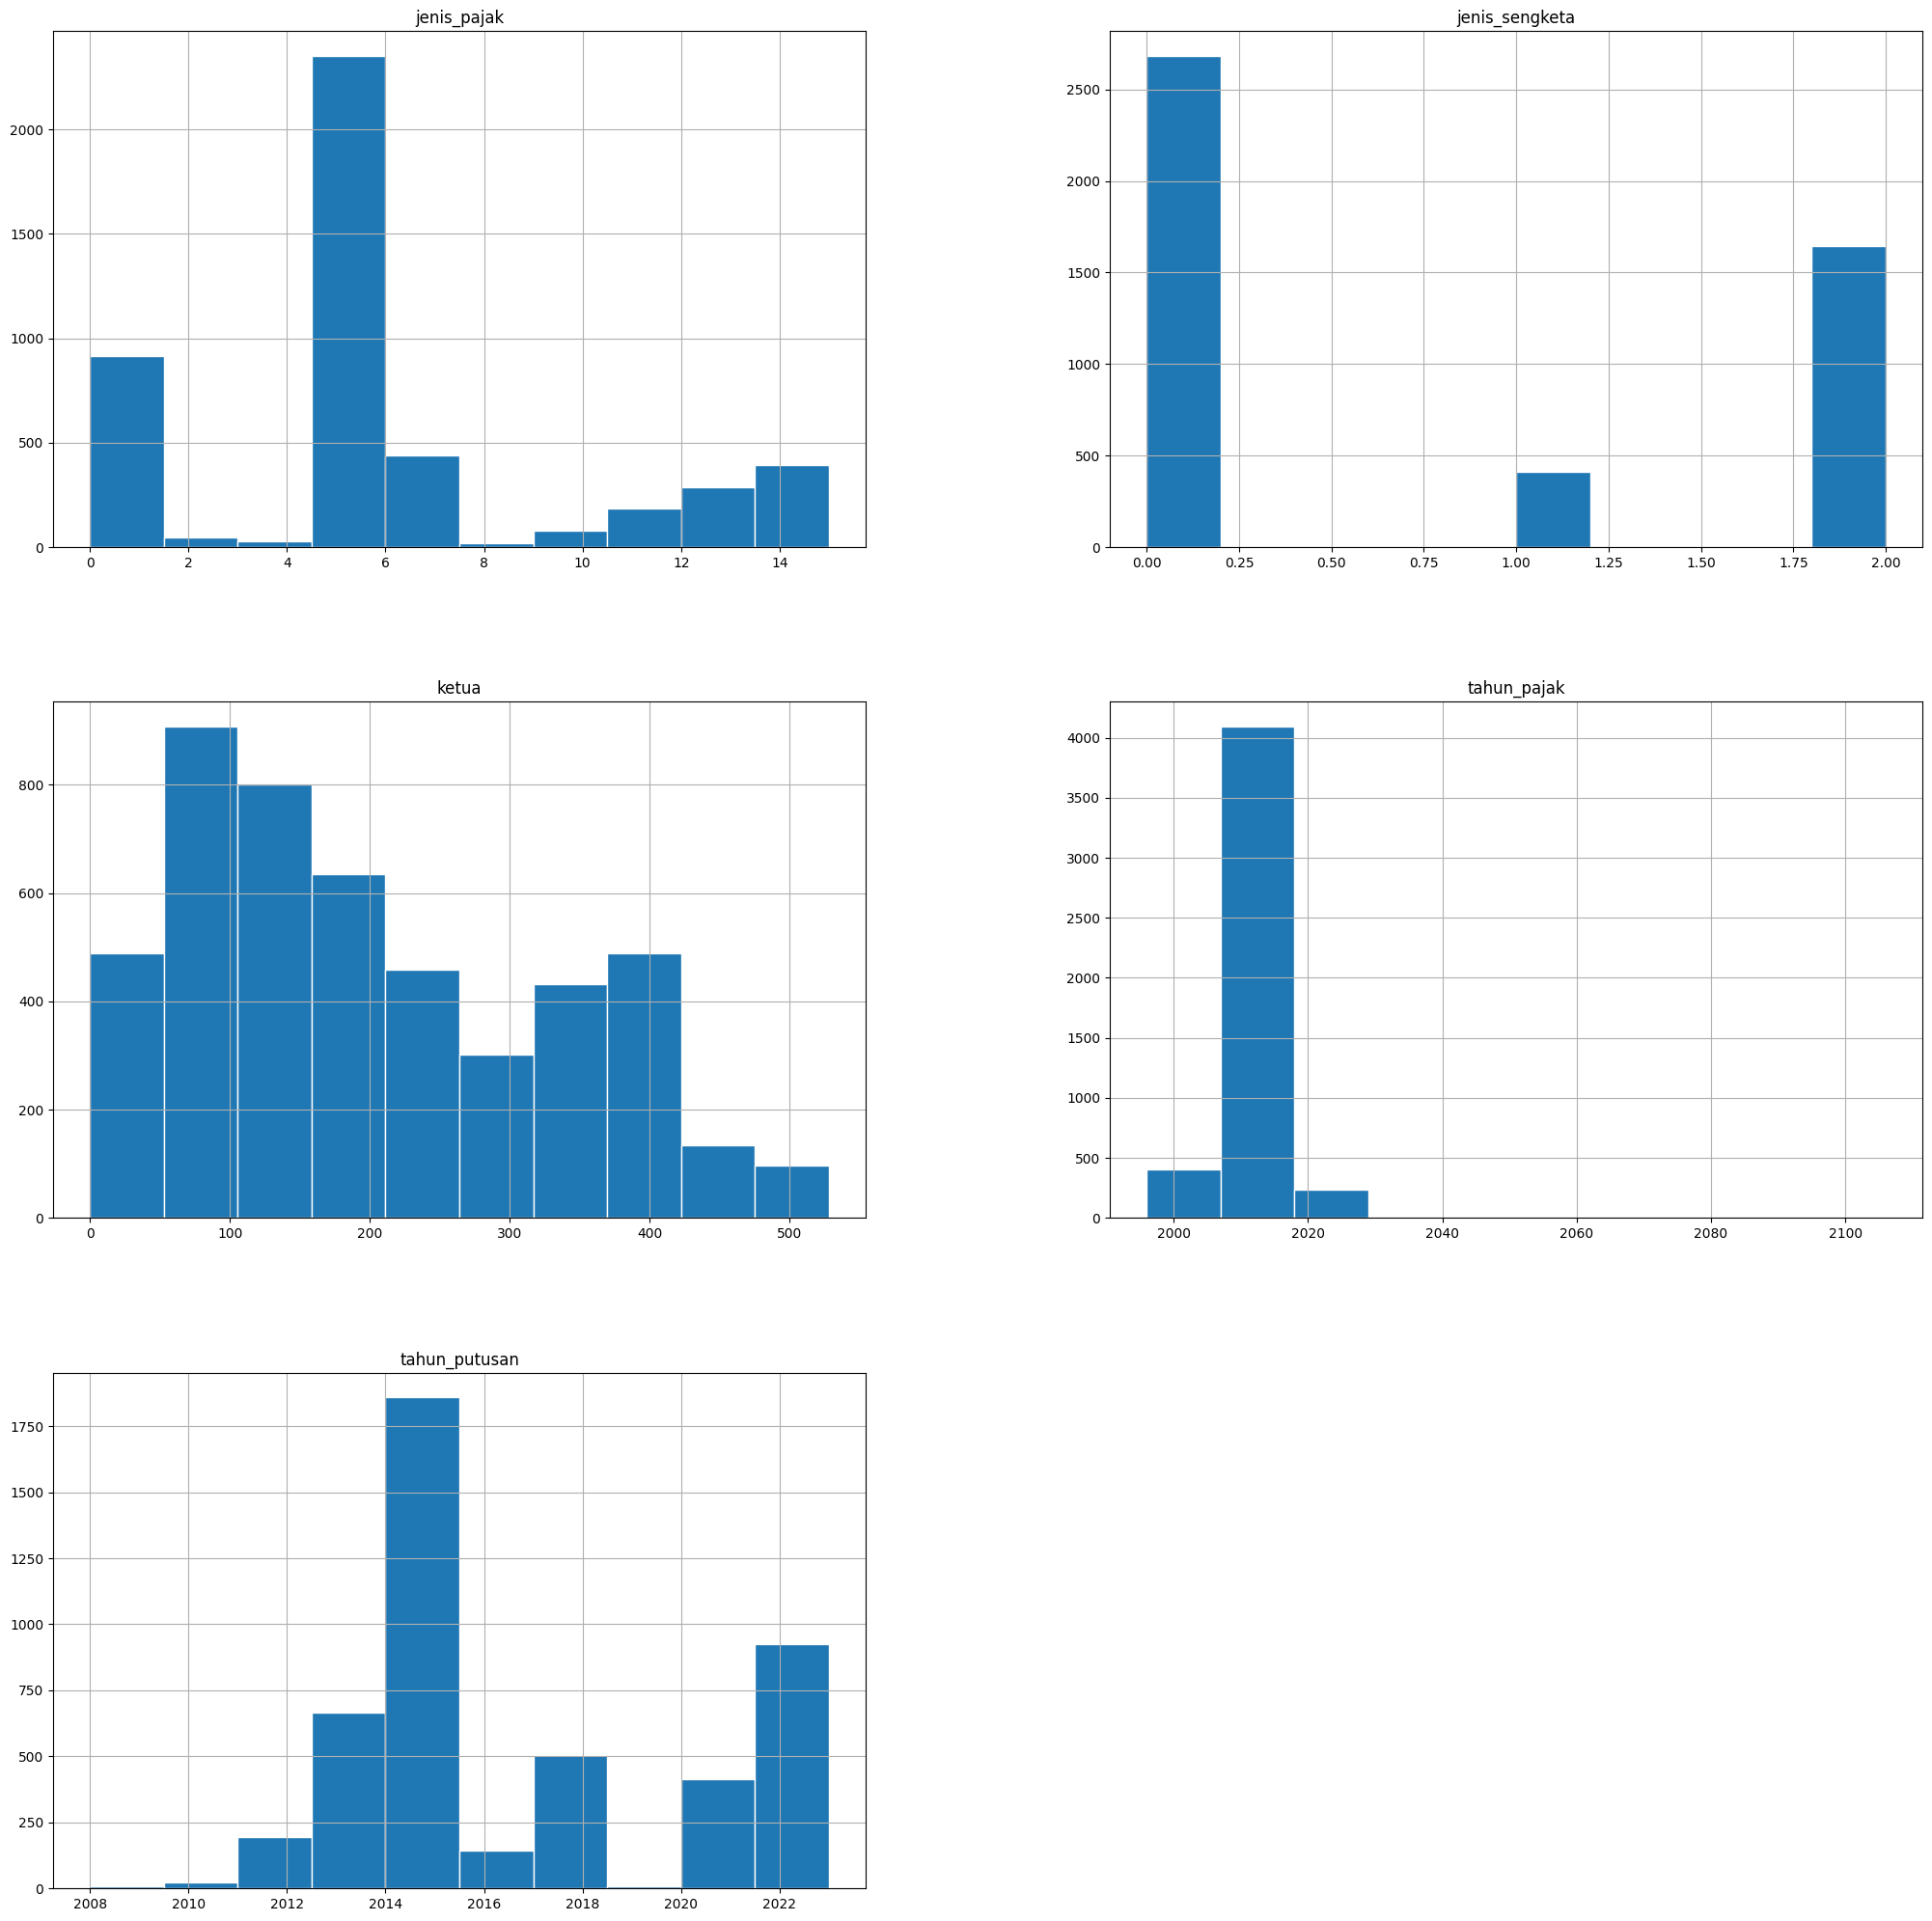

In [ ]:
df_gabung.select_dtypes('int').hist(figsize=(25,25), ec='w')
plt.show()

Realation Between Variable

In [ ]:
def color_(value):
    if value < 0 :
        color = 'red'
    elif value == 1 :
        color = 'blue'
    else:
        color = 'green'
    return 'color: %s' % color
df_gabung.select_dtypes('int').corr().style.applymap(color_)

,jenis_pajak,jenis_sengketa,ketua,tahun_pajak,tahun_putusan
jenis_pajak,1.000000,0.040682,-0.116144,-0.120135,0.014094
jenis_sengketa,0.040682,1.000000,-0.216442,-0.070771,0.328779
ketua,-0.116144,-0.216442,1.000000,0.005755,-0.272511
tahun_pajak,-0.120135,-0.070771,0.005755,1.000000,0.500216
tahun_putusan,0.014094,0.328779,-0.272511,0.500216,1.000000


In [ ]:
df_gabung.select_dtypes('int').cov().style.applymap(color_)

,jenis_pajak,jenis_sengketa,ketua,tahun_pajak,tahun_putusan
jenis_pajak,15.934433,0.151053,-60.777555,-2.306454,0.197846
jenis_sengketa,0.151053,0.865212,-26.392536,-0.316606,1.075438
ketua,-60.777555,-26.392536,17185.284152,3.628691,-125.627078
tahun_pajak,-2.306454,-0.316606,3.628691,23.131937,8.460273
tahun_putusan,0.197846,1.075438,-125.627078,8.460273,12.366349


Correlation

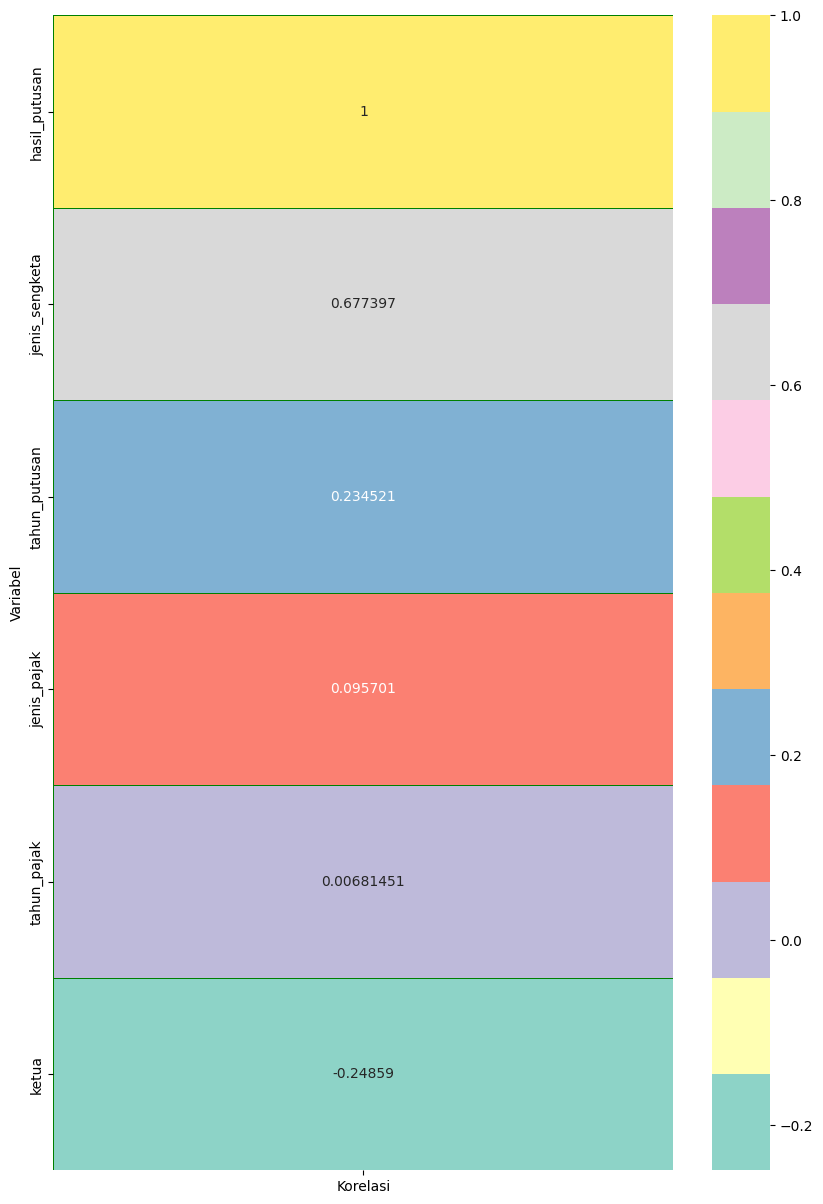

In [ ]:
corr = df_gabung.corrwith(df_gabung['hasil_putusan'],method='spearman').reset_index()

corr.columns = ['Variabel','Korelasi']
corr = corr.set_index('Variabel')
corr = corr.sort_values(by=['Korelasi'], ascending = False).head(10)

plt.figure(figsize=(10, 15))
fig = sns.heatmap(corr, annot=True, fmt="g", cmap='Set3', linewidths=0.4, linecolor='green')

plt.title("", fontsize=20)
plt.show()

# Building Classification Model

1. Logistic Regression
2. K-Nearest Classifier
3. Decision Tree
4. Naive Bayes

In [ ]:
X = df_gabung.drop(['hasil_putusan'],axis = 1)
target = df_gabung['hasil_putusan']
X_train, X_test, Y_train, Y_test = train_test_split(X, target, test_size= 0.3, random_state = 0)

In [ ]:
def ml_model(X_train,X_test, Y_train, Y_test):
  MLA = [LogisticRegression(),KNeighborsClassifier(),DecisionTreeClassifier(),GaussianNB(),]
  MLA_columns = []
  MLA_compare = pd.DataFrame(columns = MLA_columns)
  row_index = 0
  for alg in MLA:
    predicted = alg.fit(X_train, Y_train).predict(X_test)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'Model Name'] = MLA_name
    MLA_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, Y_train), 2)
    MLA_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, Y_test), 2)
    MLA_compare.loc[row_index, 'Precision'] = round(precision_score(Y_test, predicted, average='micro'),2)
    MLA_compare.loc[row_index, 'Recall'] = round(recall_score(Y_test, predicted, average='micro'),2)
    MLA_compare.loc[row_index, 'F1 score'] = round(f1_score(Y_test, predicted, average='micro'),2)
    row_index+=1
  MLA_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)
  return MLA_compare
ml_model(X_train,X_test, Y_train, Y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model Name,Train Accuracy,Test Accuracy,Precision,Recall,F1 score
2,DecisionTreeClassifier,0.92,0.83,0.83,0.83,0.83
1,KNeighborsClassifier,0.83,0.77,0.77,0.77,0.77
3,GaussianNB,0.61,0.60,0.60,0.60,0.60
0,LogisticRegression,0.37,0.38,0.38,0.38,0.38


 Best Features?

In [ ]:
from sklearn.feature_selection import SelectKBest,mutual_info_classif
bestfeatures = SelectKBest(score_func=mutual_info_classif, k='all')
fit = bestfeatures.fit(X,target,)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']
print(featureScores.nlargest(10,'Score'))

          Feature     Score
1  jenis_sengketa  0.646876
4   tahun_putusan  0.225359
2           ketua  0.209858
3     tahun_pajak  0.067134
0     jenis_pajak  0.057430


In [ ]:
X = df_gabung[['jenis_sengketa', 'ketua', 'tahun_putusan', 'jenis_pajak', 'tahun_pajak']]
X_train, X_test, Y_train, Y_test = train_test_split(X, target, test_size= 0.3, random_state = 0)
Feature_selection = ml_model(X_train,X_test, Y_train, Y_test)
Feature_selection

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model Name,Train Accuracy,Test Accuracy,Precision,Recall,F1 score
2,DecisionTreeClassifier,0.92,0.83,0.83,0.83,0.83
1,KNeighborsClassifier,0.83,0.77,0.77,0.77,0.77
3,GaussianNB,0.61,0.60,0.60,0.60,0.60
0,LogisticRegression,0.37,0.38,0.38,0.38,0.38


# Data Imbalance

Over Sampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Initialize the RandomOverSampler
oversample = RandomOverSampler(random_state=42)

# Fit and transform the data
x_resampled, y_resampled = oversample.fit_resample(X, target)

# Now you can split the resampled data
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
print('before Oversampling:',Counter(Y_train))
oversample = RandomOverSampler(sampling_strategy='minority')
x_train1, y_train1 = oversample.fit_resample(x_train, y_train)
print('After Oversampling:',Counter(y_train1))

before Oversampling: Counter({6: 971, 3: 888, 5: 864, 2: 234, 4: 118, 9: 109, 8: 64, 7: 34, 0: 32, 1: 6})
After Oversampling: Counter({4: 1128, 8: 1128, 1: 1118, 6: 1115, 7: 1114, 0: 1112, 2: 1110, 5: 1099, 9: 1094, 3: 1093})


Counter({6: 1383, 3: 1269, 5: 1236, 2: 340, 9: 165, 4: 159, 8: 92, 7: 52, 0: 39, 1: 8})
Counter({4: 1128, 8: 1128, 1: 1118, 6: 1115, 7: 1114, 0: 1112, 2: 1110, 5: 1099, 9: 1094, 3: 1093})


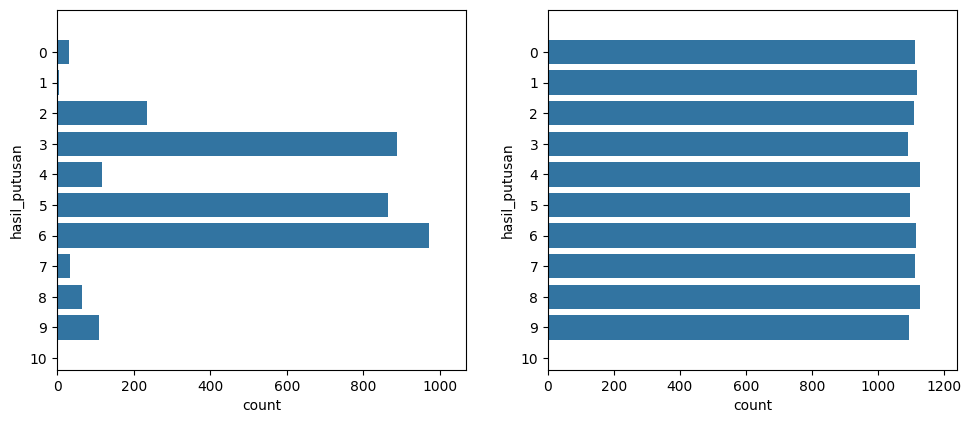

In [ ]:
print(Counter(target))
print(Counter(y_train1))
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,4.5))
fig.subplots_adjust(bottom=0.10, left=0.10, top = 0.900, right=1.00)
fig.suptitle('', fontsize = 20)
sns.set_palette("bright")
sns.countplot(Y_train, ax=ax1)
ax1.margins(0.1)
ax1.set_facecolor("#ffffff")
for p in ax1.patches:
        ax1.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
sns.set_palette("bright")
sns.countplot(y_train1, ax=ax2)
ax2.margins(0.1)
ax2.set_facecolor("#ffffff")
for p in ax2.patches:
        ax2.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
sns.set_style('dark')

Counter({4: 1128, 8: 1128, 1: 1118, 6: 1115, 7: 1114, 0: 1112, 2: 1110, 5: 1099, 9: 1094, 3: 1093})


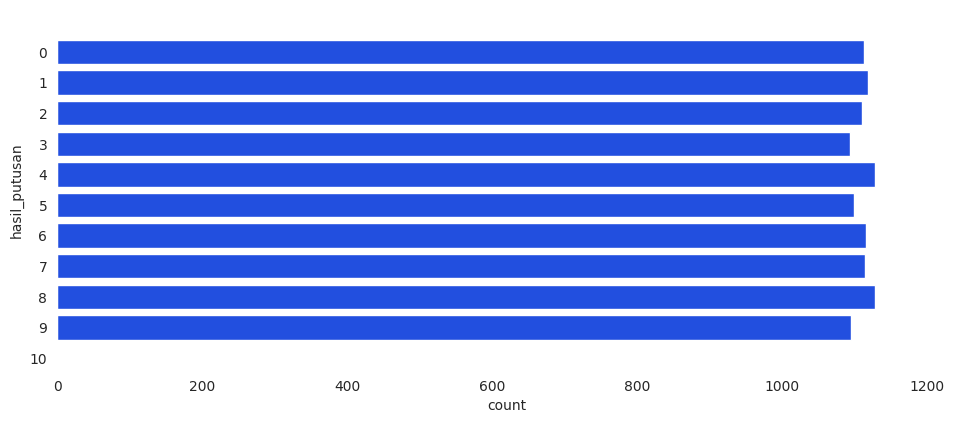

In [ ]:
print(Counter(y_train1))
fig, (ax1) = plt.subplots(1,figsize=(10,4.5))
fig.subplots_adjust(bottom=0.10, left=0.10, top = 0.900, right=1.00)
fig.suptitle('', fontsize = 20)
sns.set_palette("bright")
sns.countplot(y_train1, ax=ax1)
ax1.margins(0.1)
ax1.set_facecolor("#ffffff")
for p in ax2.patches:
        ax2.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
sns.set_style('dark')

In [ ]:
oversampling = ml_model(x_train1,x_test, y_train1, y_test)
oversampling

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model Name,Train Accuracy,Test Accuracy,Precision,Recall,F1 score
2,DecisionTreeClassifier,0.94,0.93,0.93,0.93,0.93
1,KNeighborsClassifier,0.91,0.88,0.88,0.88,0.88
3,GaussianNB,0.45,0.44,0.44,0.44,0.44
0,LogisticRegression,0.29,0.28,0.28,0.28,0.28


SMOTE

In [ ]:
print('before SMOTE:',Counter(Y_train))
#sm = SMOTE(random_state=12, ratio=1.0, n_neighbors=5)
sm = SMOTE()
x_train2, y_train2 = sm.fit_resample(X, target)
print('After SMOTE:',Counter(y_train2))

before SMOTE: Counter({6: 971, 3: 888, 5: 864, 2: 234, 4: 118, 9: 109, 8: 64, 7: 34, 0: 32, 1: 6})
After SMOTE: Counter({6: 1383, 5: 1383, 9: 1383, 3: 1383, 4: 1383, 8: 1383, 2: 1383, 1: 1383, 7: 1383, 0: 1383})


Counter({6: 1383, 3: 1269, 5: 1236, 2: 340, 9: 165, 4: 159, 8: 92, 7: 52, 0: 39, 1: 8})
Counter({6: 1383, 5: 1383, 9: 1383, 3: 1383, 4: 1383, 8: 1383, 2: 1383, 1: 1383, 7: 1383, 0: 1383})


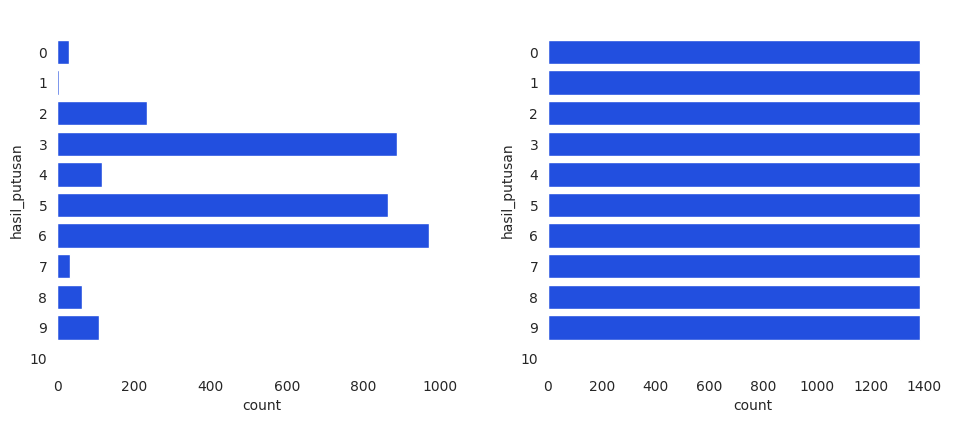

In [ ]:
print(Counter(target))
print(Counter(y_train2))
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,4.5))
fig.subplots_adjust(bottom=0.10, left=0.10, top = 0.900, right=1.00)
fig.suptitle('', fontsize = 20)
sns.set_palette("bright")
sns.countplot(Y_train, ax=ax1)
ax1.margins(0.1)
ax1.set_facecolor("#ffffff")
for p in ax1.patches:
        ax1.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
sns.set_palette("bright")
sns.countplot(y_train2, ax=ax2)
ax2.margins(0.1)
ax2.set_facecolor("#ffffff")
for p in ax2.patches:
        ax2.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
sns.set_style('dark')

Counter({6: 1383, 5: 1383, 9: 1383, 3: 1383, 4: 1383, 8: 1383, 2: 1383, 1: 1383, 7: 1383, 0: 1383})


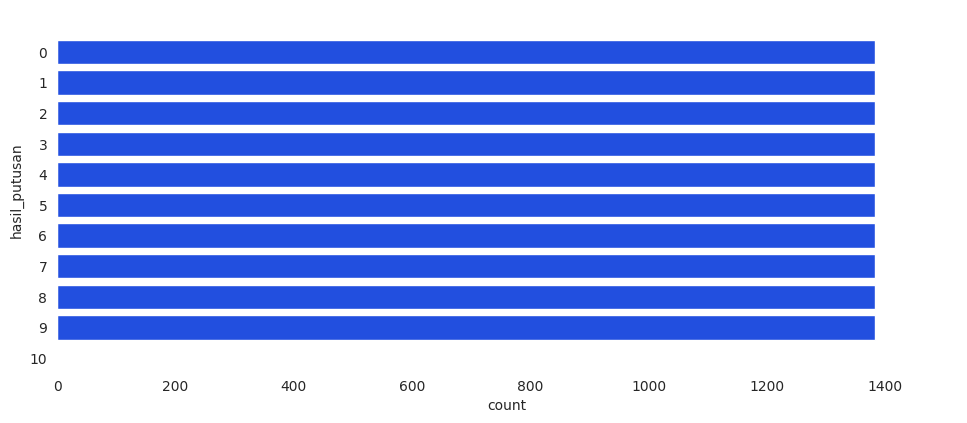

In [ ]:
print(Counter(y_train2))
fig, (ax1) = plt.subplots(1,figsize=(10,4.5))
fig.subplots_adjust(bottom=0.10, left=0.10, top = 0.900, right=1.00)
fig.suptitle('', fontsize = 20)
sns.set_palette("bright")
sns.countplot(y_train2, ax=ax1)
ax1.margins(0.1)
ax1.set_facecolor("#ffffff")
for p in ax2.patches:
        ax2.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
sns.set_style('dark')

In [ ]:
Smote = ml_model(x_train2,x_test, y_train2, y_test)
Smote

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model Name,Train Accuracy,Test Accuracy,Precision,Recall,F1 score
2,DecisionTreeClassifier,0.94,0.92,0.92,0.92,0.92
1,KNeighborsClassifier,0.88,0.86,0.86,0.86,0.86
3,GaussianNB,0.46,0.45,0.45,0.45,0.45
0,LogisticRegression,0.28,0.27,0.27,0.27,0.27


# Ensembling

In [ ]:
#import lightgbm as lgb
#from sklearn.datasets import make_regression

Over-sampling

In [ ]:
def ensemble_model(x_train1,x_test, y_train1, y_test):
  class_weight={0:0.087, 1:1}
  MLA = [XGBClassifier(n_estimators=200,learning_rate=0.1,
  tree_method = 'hist',random_state=42)]
  MLA_columns = []
  MLA_compare = pd.DataFrame(columns = MLA_columns)
  row_index = 0
  for alg in MLA:
    predicted = alg.fit(x_train1, y_train1).predict(x_test)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'Model Name'] = MLA_name
    MLA_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(x_train1, y_train1), 2)
    MLA_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(x_test, y_test), 2)
    MLA_compare.loc[row_index, 'Precision'] = round(precision_score(y_test, predicted, average='micro'),2)
    MLA_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted, average='micro'),2)
    MLA_compare.loc[row_index, 'F1 score'] = round(f1_score(y_test, predicted, average='micro'),2)
    row_index+=1
  MLA_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)
  return MLA_compare
#CatBoostClassifier(iterations=200, learning_rate=0.3,random_seed=42,task_type="GPU",verbose=False),LGBMClassifier(n_estimators=200,is_unbalance=True,learning_rate=0.1, #class_weight=class_weight,num_leaves=200,device='gpu',random_state=42,n_jobs=-1)

In [ ]:
ensemble_model(x_train1, x_test, y_train1, y_test)

,Model Name,Train Accuracy,Test Accuracy,Precision,Recall,F1 score
0,XGBClassifier,0.92,0.91,0.91,0.91,0.91


SMOTE

In [ ]:
def ensemble_model(x_train2,x_test, y_train2, y_test):
  class_weight={0:0.087, 1:1}
  MLA = [XGBClassifier(n_estimators=200,learning_rate=0.1,
  tree_method = 'hist',random_state=42)]
  MLA_columns = []
  MLA_compare = pd.DataFrame(columns = MLA_columns)
  row_index = 0
  for alg in MLA:
    predicted = alg.fit(x_train2, y_train2).predict(x_test)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'Model Name'] = MLA_name
    MLA_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(x_train2, y_train2), 2)
    MLA_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(x_test, y_test), 2)
    MLA_compare.loc[row_index, 'Precision'] = round(precision_score(y_test, predicted, average='micro'),2)
    MLA_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted, average='micro'),2)
    MLA_compare.loc[row_index, 'F1 score'] = round(f1_score(y_test, predicted, average='micro'),2)
    row_index+=1
  MLA_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)
  return MLA_compare
#CatBoostClassifier(iterations=200, learning_rate=0.3,random_seed=42,task_type="GPU",verbose=False),LGBMClassifier(n_estimators=200,is_unbalance=True,learning_rate=0.1, #class_weight=class_weight,num_leaves=200,device='gpu',random_state=42,n_jobs=-1)

In [ ]:
ensemble_model(x_train2, x_test, y_train2, y_test)

,Model Name,Train Accuracy,Test Accuracy,Precision,Recall,F1 score
0,XGBClassifier,0.92,0.91,0.91,0.91,0.91
